# Capstone project

## Step 1: Split the data into training and testing

Data source: https://www.kaggle.com/mlg-ulb/creditcardfraud

Data information:

The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
We have 492 frauds out of 284,807 transactions. 
Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Goal:

Create a binary classifier that can take in 29 features for a credit card and produce an accurate fraudulent or non fraudulent classification on the purchase.

Feature Creation information:
* Each dimension value is type float.
* The result is type integer (0 or 1)
* Every dimensions value is mandatory (No empty values)

Model Definition:
- F1 will be the scoring method used. As precision on fraud is important, The highest possible, the better.


In [2]:
!pip install keras --upgrade

    100% |################################| 317kB 3.3MB/s eta 0:00:01
    100% |################################| 17.2MB 882kB/s eta 0:00:01
    100% |################################| 51kB 2.4MB/s eta 0:00:01
    100% |################################| 25.1MB 723kB/s eta 0:00:01
    100% |################################| 276kB 4.2MB/s eta 0:00:01
    100% |################################| 51kB 2.3MB/s eta 0:00:01
    100% |################################| 2.8MB 2.8MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /home/spark/shared/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built pyyaml
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
pyspark 2.3.3 requires py4j==0.10.7, which is not installed.


In [3]:
# The code was removed by Watson Studio for sharing.

[Row(Time='0', V1='-1.3598071336738', V2='-0.0727811733098497', V3='2.53634673796914', V4='1.37815522427443', V5='-0.338320769942518', V6='0.462387777762292', V7='0.239598554061257', V8='0.0986979012610507', V9='0.363786969611213', V10='0.0907941719789316', V11='-0.551599533260813', V12='-0.617800855762348', V13='-0.991389847235408', V14='-0.311169353699879', V15='1.46817697209427', V16='-0.470400525259478', V17='0.207971241929242', V18='0.0257905801985591', V19='0.403992960255733', V20='0.251412098239705', V21='-0.018306777944153', V22='0.277837575558899', V23='-0.110473910188767', V24='0.0669280749146731', V25='0.128539358273528', V26='-0.189114843888824', V27='0.133558376740387', V28='-0.0210530534538215', Amount='149.62', Class='0'),
 Row(Time='0', V1='1.19185711131486', V2='0.26615071205963', V3='0.16648011335321', V4='0.448154078460911', V5='0.0600176492822243', V6='-0.0823608088155687', V7='-0.0788029833323113', V8='0.0851016549148104', V9='-0.255425128109186', V10='-0.166974414

In [4]:
def split_training_and_testing_from_data(df, ratio_to_save=0.8, data_imbalance_ratio=0.1):
    # Split the data into train and test sets
    train_data_class_0, test_data_class_0 = df.filter(df.Class == 0).randomSplit([ratio_to_save, 1-ratio_to_save])
    train_data_class_1, test_data_class_1 = df.filter(df.Class == 1).randomSplit([ratio_to_save, 1-ratio_to_save])

    # Since there is a huge class imbalance, I will remove data_imbalance_ratio of the data to improve the balance
    train_data_class_0, _ = train_data_class_0.randomSplit([data_imbalance_ratio, 1-data_imbalance_ratio])
    
    train_data = train_data_class_0.union(train_data_class_1)
    test_data = test_data_class_0.union(test_data_class_1)
    
    return train_data, test_data

In [5]:
from pyspark.sql.types import IntegerType

def split_data_and_labels(df):
    labels = df.select("Class").withColumn("Class", df_data_2["Class"].cast(IntegerType()))
    data = df.drop("Time").drop("Class").drop("Amount")
    
    return (data, labels)

In [6]:
# Generate the train and test data
ratio_to_save = 0.8
data_imbalance_ratio = 0.1

train_dataset, test_dataset = split_training_and_testing_from_data(df_data_2, ratio_to_save=ratio_to_save, data_imbalance_ratio=data_imbalance_ratio)

In [7]:
# Split the data and labels apart
train_data, train_labels = split_data_and_labels(train_dataset)
test_data, test_labels = split_data_and_labels(test_dataset)

## Step 2: Analyze the data (Training data only)

In [8]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [9]:
# Produce the correlation matrix of the columns data (28 x 28)
col_names = train_data.columns
features = train_data.rdd.map(lambda row: row[0:])

corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.to_string())

           V1        V2        V3        V4        V5        V6        V7        V8        V9       V10       V11       V12       V13       V14       V15       V16       V17       V18       V19       V20       V21       V22       V23       V24       V25       V26       V27       V28
V1   1.000000 -0.102850  0.259032 -0.156385  0.162960  0.085687  0.319896 -0.033438  0.142818  0.255034 -0.151047  0.225867  0.005582  0.194721  0.018619  0.219432  0.287771  0.176490 -0.044840 -0.085135 -0.015728 -0.005546 -0.022221 -0.000064  0.005541  0.005075 -0.003008  0.137799
V2  -0.102850  1.000000 -0.216564  0.118218 -0.223844  0.007573 -0.187965  0.005385 -0.119448 -0.219422  0.151248 -0.224331  0.003135 -0.213198 -0.008854 -0.185161 -0.242342 -0.136599  0.043588 -0.042220  0.001033  0.009020 -0.027857  0.003474  0.015586 -0.008001 -0.077637  0.098967
V3   0.259032 -0.216564  1.000000 -0.229391  0.277209  0.092453  0.403762 -0.086364  0.215580  0.394862 -0.269217  0.379739  0.002720  0.363434  0.0

It appears that there is not much correlation between these 29 features. Amount appears to have the highest, due to it's un-normalized values.
**There results are a good indication that our features are all good to use**

## Step 3: Preprocess the data for the model

In [10]:
import pip

try:
    __import__('keras')
except ImportError:
    pip.main(['install', 'keras']) 
    
try:
    __import__('h5py')
except ImportError:
    pip.main(['install', 'h5py']) 

import sys
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import Callback
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

Using TensorFlow backend.


In [11]:
def scaleData(data):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

### Fetch the data for training

In [12]:
# Input data needs to be in a list of numpy arrays
new_train_data = train_data.rdd.map(np.array).collect()
train_data_clean = scaleData(np.array(new_train_data))

# Need to use to_categorical so that the integers are converted properly for Keras
new_train_labels = train_labels.rdd.map(lambda row: row["Class"]).collect()
train_labels_clean = np.array(new_train_labels)
#train_labels_clean = to_categorical(new_train_labels, num_classes=2)

print(train_data_clean.shape)
print(train_labels_clean.shape)

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype <U21 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(22897, 28)
(22897,)


### Fetch the data for testing

In [13]:
new_test_data = test_data.rdd.map(np.array).collect()
test_data_clean = scaleData(np.array(new_test_data))

new_test_labels = test_labels.rdd.map(lambda row: row["Class"]).collect()
test_labels_clean = np.array(new_test_labels)
#test_labels_clean = to_categorical(new_test_labels, num_classes=2)

print(test_data_clean.shape)
print(test_labels_clean.shape)

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype <U21 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(56652, 28)
(56652,)


In [14]:
num_features = len(train_data.columns)
num_outputs = 1

# Check to make sure our data is the expected dimensions
assert len(train_data_clean[0]) == num_features
#assert len(train_labels_clean[0]) == num_outputs

## Set up the AI model

In [ ]:
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import f1_score

def f1_score_2(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [101]:
model = Sequential()
model.add(Dense(1024, input_shape=(num_features,), activation='relu')) # Add first layer. Make sure to specify input shape
model.add(Dropout(0.1)) # Add second layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1)) # Add second layer
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_outputs, activation='sigmoid')) # Add third layer

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1024)              29696     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total para

In [102]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', f1_score]
)

In [103]:
#some learners constantly reported 502 errors in Watson Studio. 
#This is due to the limited resources in the free tier and the heavy resource consumption of Keras.
#This is a workaround to limit resource consumption

from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

Create Callback method

In [104]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        sys.stdout.write(str(logs.get('loss'))+str(', '))
        sys.stdout.flush()
        self.losses.append(logs.get('loss'))
        
lr = LossHistory()

Define trainging and scoring methods

In [105]:
number_of_epochs = 50

def train(data, label, class_weights):
    # validation_data=(data, label),
    return model.fit(data, label, epochs=number_of_epochs, batch_size=128, class_weight=class_weights, verbose=0, shuffle=True, callbacks=[lr])

def score(data):
    return model.predict(data)

### Since our data isn't balanced, we must used class weights to help in training

In [106]:
class_weights = compute_class_weight('balanced', np.unique(new_test_labels), new_test_labels)

print(class_weights)

[   0.50079559  314.73333333]


## Train the model

In [ ]:
train(train_data_clean, train_labels_clean, class_weights)

0.0558296993654, 0.0265407475623, 0.0258198859129, 

### Lets plot the losses

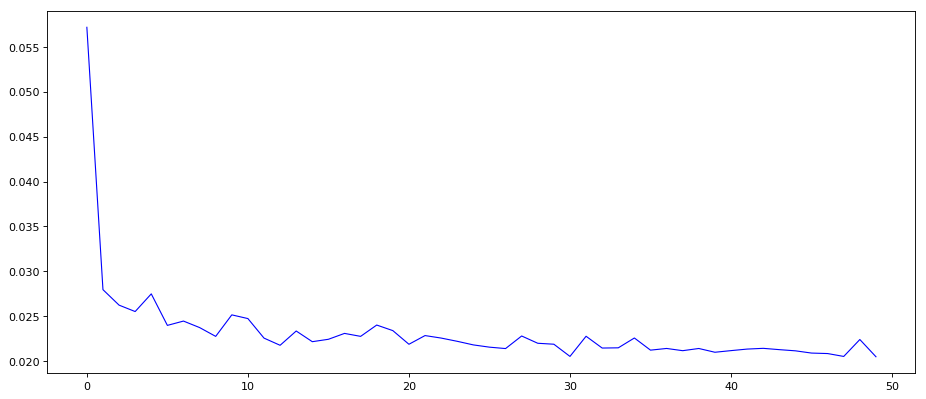

In [24]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(lr.losses)
ax.plot(range(0,size), lr.losses, '-', color='blue', animated = True, linewidth=1)

### Let's take a look at the confusion matrix

In [63]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [62]:
from sklearn.metrics import confusion_matrix

y_true = test_labels_clean
y_pred = np.array([model.predict(np.array([np.array(temp_data)]))[0][0] for temp_data in test_data_clean])

# Apply softmax with cut off @ 0.6 for predicted values
y_pred = np.array(list(map(lambda p: int(p > 0.6), y_pred)))

### Visualize Confusion Matrix

Confusion matrix, without normalization
[[56537    25]
 [   15    75]]


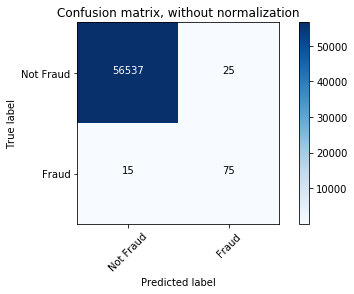

In [65]:
class_names = ["Not Fraud", "Fraud"]

cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[  9.99558007e-01   4.41992857e-04]
 [  1.66666667e-01   8.33333333e-01]]


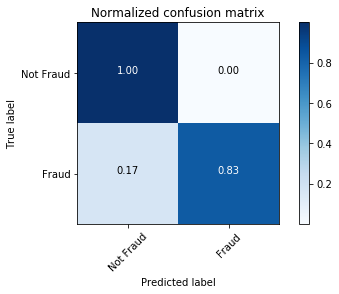

In [60]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### These results look good! Only 17% missclassifications for fraud passing as not fraud.

### Lets score the model

In [66]:
score = model.evaluate(x=test_data_clean, y=test_labels_clean, batch_size=128)

56652/56652 [==============================] - 5s 95us/step


In [67]:
print(model.metrics_names)
print(score)

['loss', 'acc', 'f1_score']
[0.0035086534086180587, 0.99927628324385842, 0.0034540497271058285]


Looks like we have good loss, accuracy and F1 score.

### Visualize the results of the model

In [86]:
guesses_true = []
guesses_false = []
max_count = 500
count = 0

for i, answer in enumerate(test_labels_clean):
    if answer != 0:
        continue
    
    count += 1
    if count > max_count:
        break
    guesses_true.append(model.predict(np.array([np.array(test_data_clean[i])]))[0][0])

count = 0
for i, answer in enumerate(test_labels_clean):
    if answer != 1:
        continue
    
    count += 1
    if count > max_count:
        break
    guesses_false.append(model.predict(np.array([np.array(test_data_clean[i])]))[0][0])

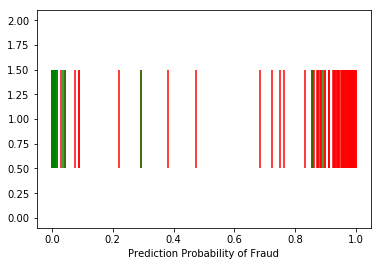

In [88]:
# Plot the true vs false probabilities to see out training

plt.eventplot(guesses_false, orientation='horizontal', colors='r')
plt.eventplot(guesses_true, orientation='horizontal', colors='g')

plt.xlabel('Prediction Probability of Fraud')
plt.show()

#### Looks like there is a good distinction between the classifications.